# **Challenge Telecom X Parte 2 - Previsão de Evasão de Clientes (Churn)**

# 📌 **Proposta do desafio**

Dando sequência à análise de evasão de clientes realizada anteriormente, esta nova etapa tem como objetivo desenvolver modelos preditivos que identifiquem quais clientes apresentam maior probabilidade de cancelar os serviços contratados.



#📝**Extração dos Dados**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
#Carregando os dados tratados do arquivo CSV
import pandas as pd

# URL dos dados
url = "https://raw.githubusercontent.com/lilaharada/Desafio_TelecomX_Parte2_Previsao_Churn/main/telecomx_clean_data.csv"
df = pd.read_csv(url)
df.head()

,ID_Cliente,Evasao,Genero,Idoso,Possui_Conjuge,Possui_Dependentes,Meses_Contrato,Servico_Telefone,Multiplas_Linhas,Servico_Internet,...,Protecao_Dispositivo,Suporte_Tecnico,Streaming_TV,Streaming_Filmes,Tipo_Contrato,Fatura_Digital,Forma_Pagamento,Contas_Diarias,Gasto_Mensal,Gasto_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40


In [ ]:
# Ver as colunas disponíveis
df.columns

Index(['ID_Cliente', 'Evasao', 'Genero', 'Idoso', 'Possui_Conjuge',
       'Possui_Dependentes', 'Meses_Contrato', 'Servico_Telefone',
       'Multiplas_Linhas', 'Servico_Internet', 'Seguranca_Online',
       'Backup_Online', 'Protecao_Dispositivo', 'Suporte_Tecnico',
       'Streaming_TV', 'Streaming_Filmes', 'Tipo_Contrato', 'Fatura_Digital',
       'Forma_Pagamento', 'Contas_Diarias', 'Gasto_Mensal', 'Gasto_Total'],
      dtype='object')

In [ ]:
#verificar a estrutura geral
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Cliente            7043 non-null   object 
 1   Evasao                7043 non-null   object 
 2   Genero                7043 non-null   object 
 3   Idoso                 7043 non-null   int64  
 4   Possui_Conjuge        7043 non-null   object 
 5   Possui_Dependentes    7043 non-null   object 
 6   Meses_Contrato        7043 non-null   int64  
 7   Servico_Telefone      7043 non-null   object 
 8   Multiplas_Linhas      7043 non-null   object 
 9   Servico_Internet      7043 non-null   object 
 10  Seguranca_Online      7043 non-null   object 
 11  Backup_Online         7043 non-null   object 
 12  Protecao_Dispositivo  7043 non-null   object 
 13  Suporte_Tecnico       7043 non-null   object 
 14  Streaming_TV          7043 non-null   object 
 15  Streaming_Filmes     

## 🔧 **Preparação dos Dados**

###✅1. Remoção de Colunas Irrelevantes

Colunas que não têm valor preditivo, como identificadores únicos, devem ser removidas para evitar ruído no modelo.

In [ ]:
# Remover a coluna 'ID_Cliente'
df = df.drop(columns=['ID_Cliente'])

###✅ 2. Encoding de Variáveis Categóricas

As variáveis categóricas são transformadas em formato numérico para para serem compreendidas por algoritmos de Machine Learning. Um método de codificação adequado é o one-hot encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Identificar colunas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

y = df["Evasao"].map({"No":0, "Yes":1})

# Aplicar One-Hot Encoding
encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(df[categorical_cols]).toarray()
encoded_cols = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Combinar com as colunas numéricas
numeric_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
df_processed = pd.concat([df[numeric_cols], encoded_cols], axis=1)

# Verificar se 'Evasao' está nas colunas numéricas (pode ser 0/1)
if 'Evasao' not in numeric_cols and 'Evasao' in df.columns:
    df_processed['Evasao'] = df['Evasao']

###✅3. Verificação da Proporção de Evasão

Analisar se existe desbalanceamento de classes. Se houver uma diferença muito grande entre as classes (ex.: 80% vs 20%), técnicas de balanceamento serão necessárias.

Distribuição de Evasão:
Evasao
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


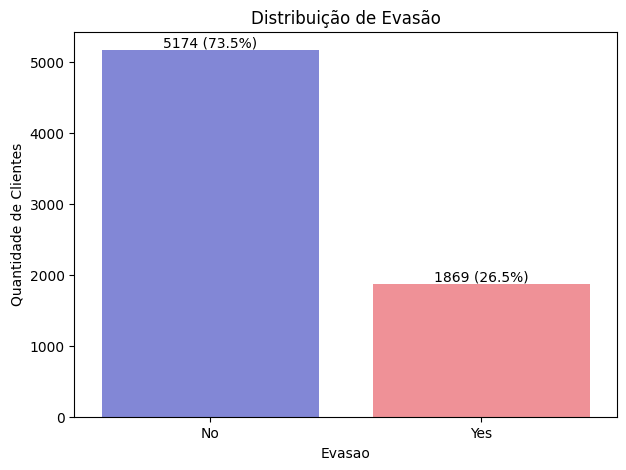

In [ ]:
# Verificar balanceamento das classes
churn_distribution = df_processed['Evasao'].value_counts(normalize=True)
print(f"Distribuição de Evasão:\n{churn_distribution}")

# Contagem dos valores da coluna 'Evasao' no DataFrame df_dados
contagem = df['Evasao'].value_counts()
labels = contagem.index
sizes = contagem.values

# Remover estilo pré-definido do Colab
plt.style.use('default')

# Visualizar a distribuição
import matplotlib.pyplot as plt
import seaborn as sns

# Criar gráfico de barras
fig, ax = plt.subplots(figsize=(7, 5))
barras = ax.bar(labels, sizes, edgecolor=None)

# Adicionar rótulos nas barras
for barra in barras:
    altura = barra.get_height()
    ax.text(
        barra.get_x() + barra.get_width()/2,
        altura + 0.5,  # ligeiramente acima da barra
        f'{altura} ({altura/sizes.sum():.1%})',
        ha='center',
        va='bottom',
        fontsize=10
    )

 # Título e formatação
sns.countplot(x='Evasao', data=df, hue='Evasao', palette=['#747ae4', '#ff818a'], legend=False)
plt.title('Distribuição de Evasão')
plt.ylabel('Quantidade de Clientes')
plt.show()

# 🎯 **Correlação e Seleção de Variáveis**

###✅ 1. Análise de Correlação

Foi criado uma matriz de correlação para identificar relações entre variáveis numéricas, para focar especialmente quais variáveis apresentam maior correlação com a evasão, pois elas podem ser fortes candidatas para o modelo preditivo.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

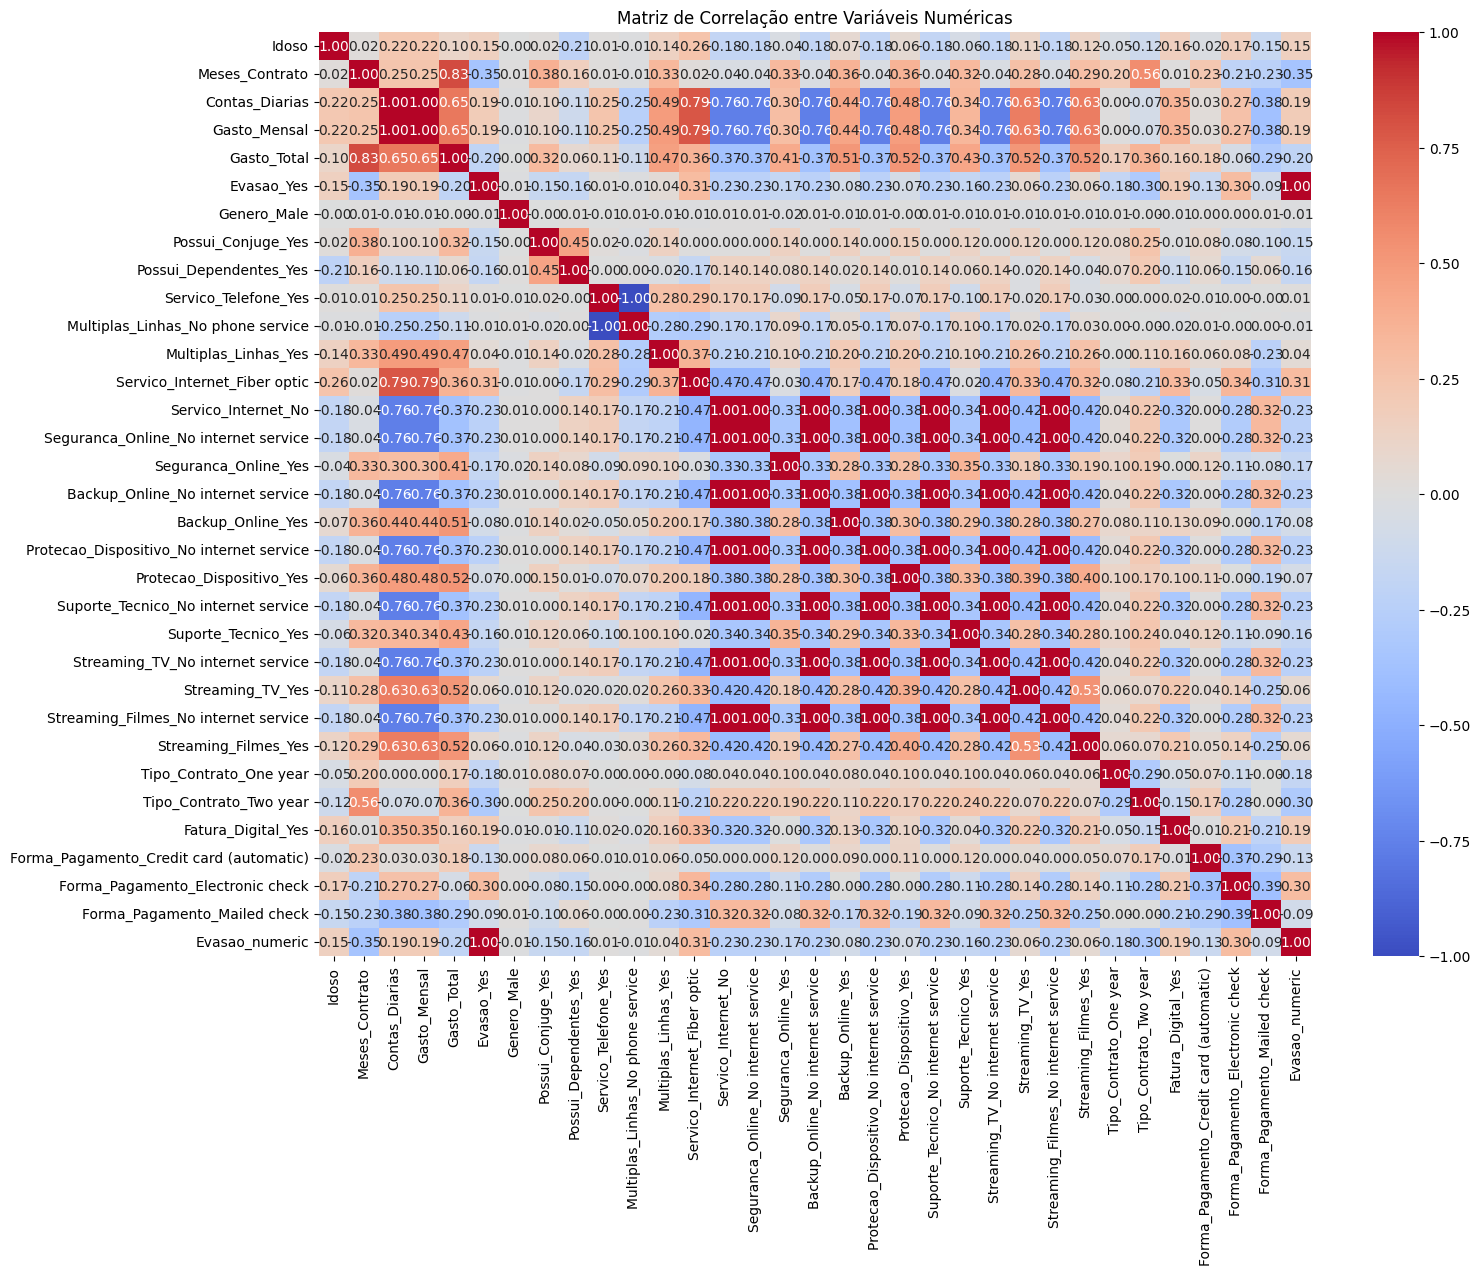

In [ ]:
# Converter coluna 'Evasao' para numerica (0 para No, 1 para Yes)
df_processed['Evasao_numeric'] = df_processed['Evasao'].apply(lambda x: 1 if x == 'Yes' else 0)

# Calcular matriz de correlação apenas para variáveis numéricas
correlation_matrix = df_processed.select_dtypes(include=['int64', 'float64']).corr()

# Plotar heatmap da matriz de correlação
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Variáveis Numéricas')

plt.show()

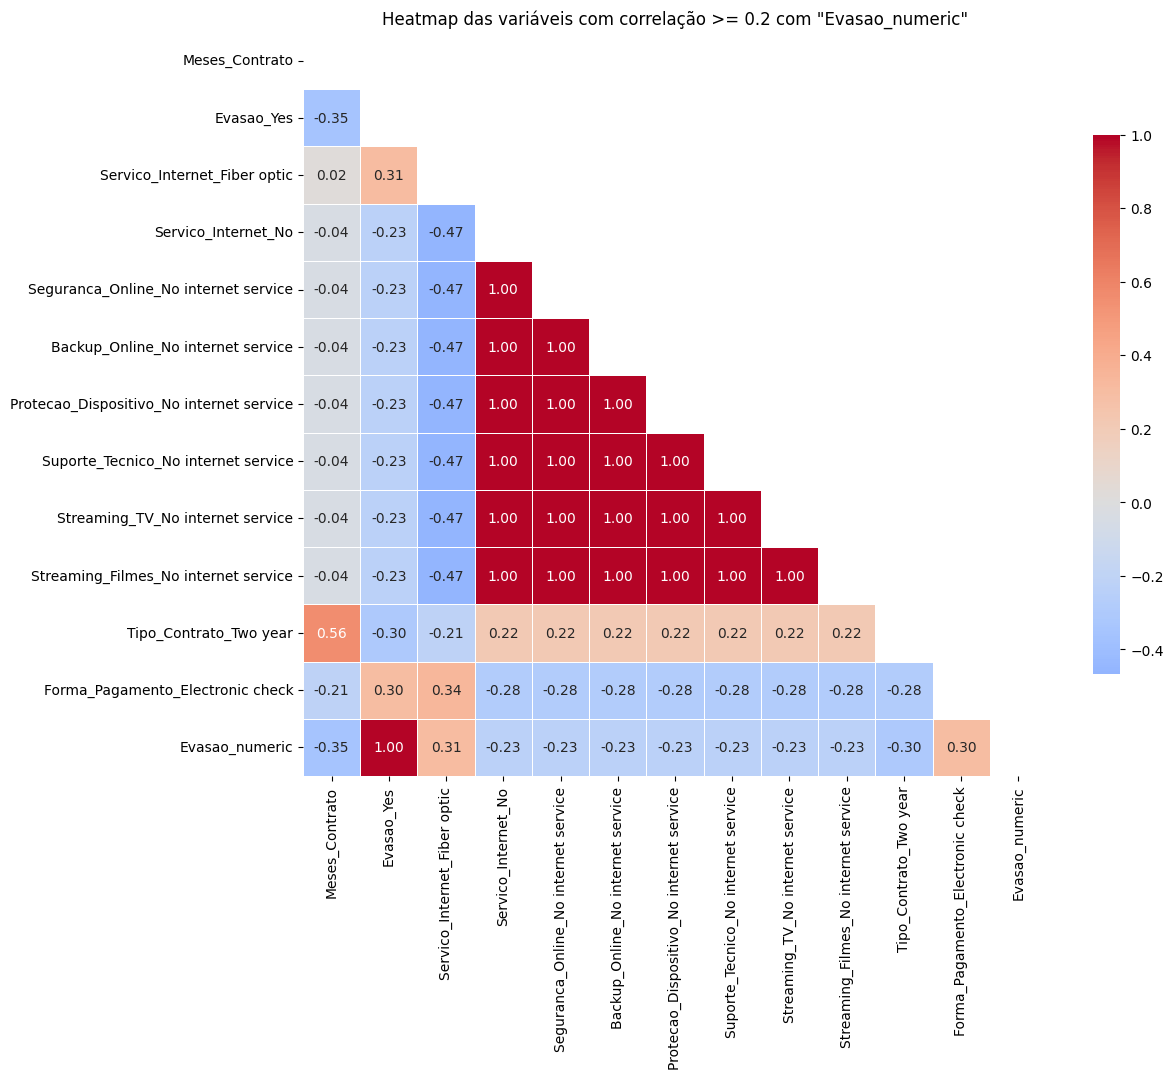

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir a variável alvo
target_var = 'Evasao_numeric'

# Definir o limiar mínimo de correlação absoluta para seleção
limiar = 0.2

# Filtrar variáveis que tenham correlação absoluta >= limiar com a variável alvo
# Isso cria uma lista com as variáveis relevantes
variaveis_relevantes = correlation_matrix.index[abs(correlation_matrix[target_var]) >= limiar].tolist()

# Garantir que a variável alvo está na lista (se não estiver, adiciona)
if target_var not in variaveis_relevantes:
    variaveis_relevantes.append(target_var)

# Criar uma matriz de correlação somente com as variáveis selecionadas
corr_filtrada = correlation_matrix.loc[variaveis_relevantes, variaveis_relevantes]

# Gerar uma máscara para esconder o triângulo superior da matriz (incluindo diagonal)
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Plotar o heatmap com a máscara aplicada para melhor visualização
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara
)
plt.title(f'Heatmap das variáveis com correlação >= {limiar} com "{target_var}"')
plt.show()

Variáveis com maior correlação com Evasao:
Evasao_Yes                                  1.000000
Evasao_numeric                              1.000000
Servico_Internet_Fiber optic                0.308020
Forma_Pagamento_Electronic check            0.301919
Contas_Diarias                              0.193412
Gasto_Mensal                                0.193356
Fatura_Digital_Yes                          0.191825
Idoso                                       0.150889
Streaming_TV_Yes                            0.063228
Streaming_Filmes_Yes                        0.061382
Multiplas_Linhas_Yes                        0.040102
Servico_Telefone_Yes                        0.011942
Genero_Male                                -0.008612
Multiplas_Linhas_No phone service          -0.011942
Protecao_Dispositivo_Yes                   -0.066160
Backup_Online_Yes                          -0.082255
Forma_Pagamento_Mailed check               -0.091683
Forma_Pagamento_Credit card (automatic)    -0.134302
Pos

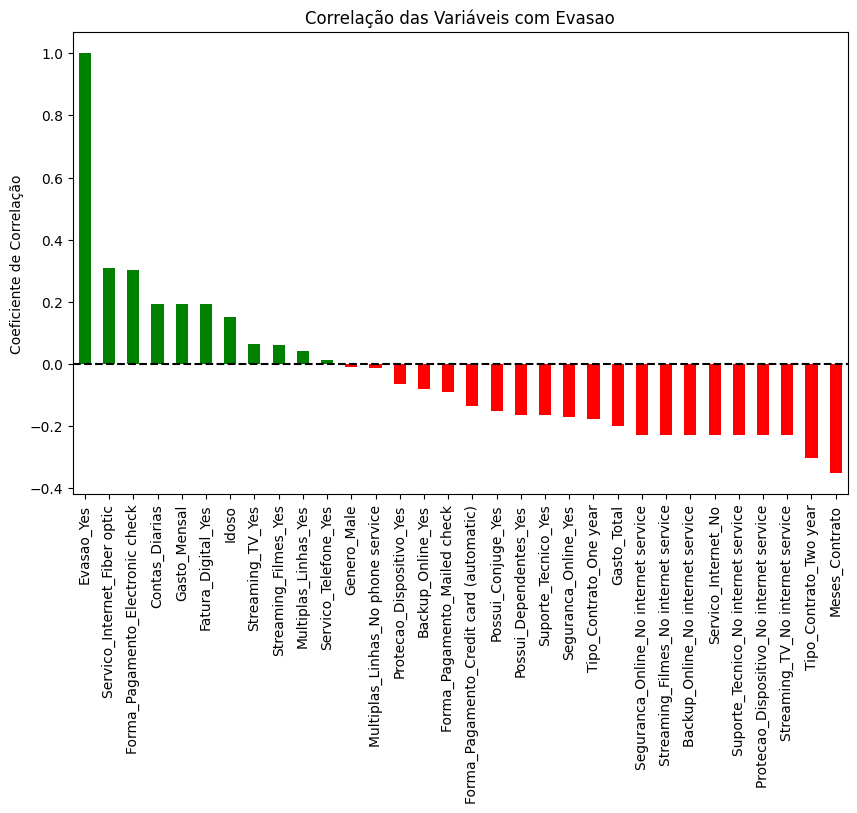

In [ ]:
# Focar na correlação com a variável target (Evasao_numeric)
churn_corr = correlation_matrix['Evasao_numeric'].sort_values(ascending=False)

# Exibir as variáveis com maior correlação (positiva ou negativa) com Evasao
print("Variáveis com maior correlação com Evasao:")
print(churn_corr)

# Criar gráfico de barras com as correlações mais significativas
plt.figure(figsize=(10, 6))
churn_corr.drop('Evasao_numeric').plot(kind='bar', color=['green' if x > 0 else 'red' for x in churn_corr.drop('Evasao_numeric')])
plt.title('Correlação das Variáveis com Evasao')
plt.ylabel('Coeficiente de Correlação')
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

###✅ 2. Análises Direcionadas

O objetivo aqui é entender o comportamento de variáveis que, teoricamente, podem influenciar a evasão.

Gráficos como boxplots ou dispersão (scatter plots) são excelentes para visualizar padrões e possíveis tendências.

**a) Tempo de Contrato × Evasão**

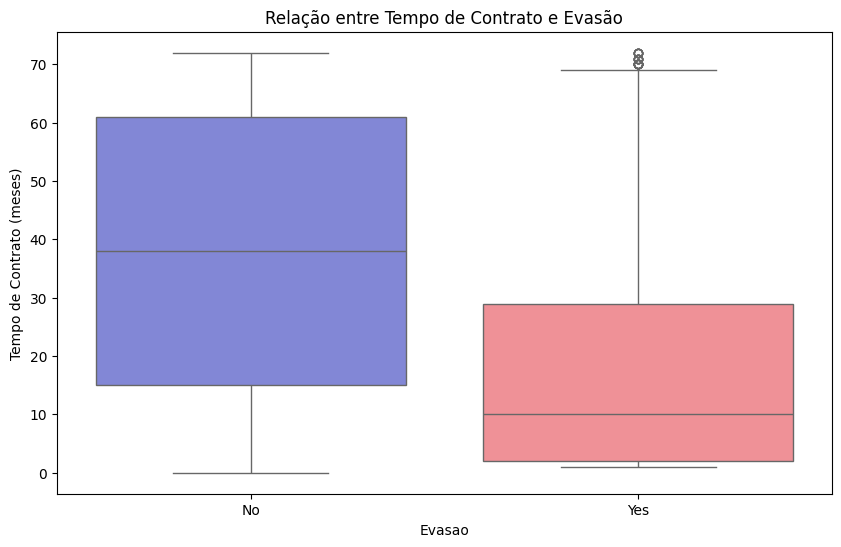

In [ ]:
# Boxplot para visualizar a relação entre tempo de contrato e churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Evasao', y='Meses_Contrato', data=df, hue='Evasao', palette=['#747ae4', '#ff818a'], legend=False)
plt.title('Relação entre Tempo de Contrato e Evasão')
plt.xlabel('Evasao')
plt.ylabel('Tempo de Contrato (meses)')
plt.show()

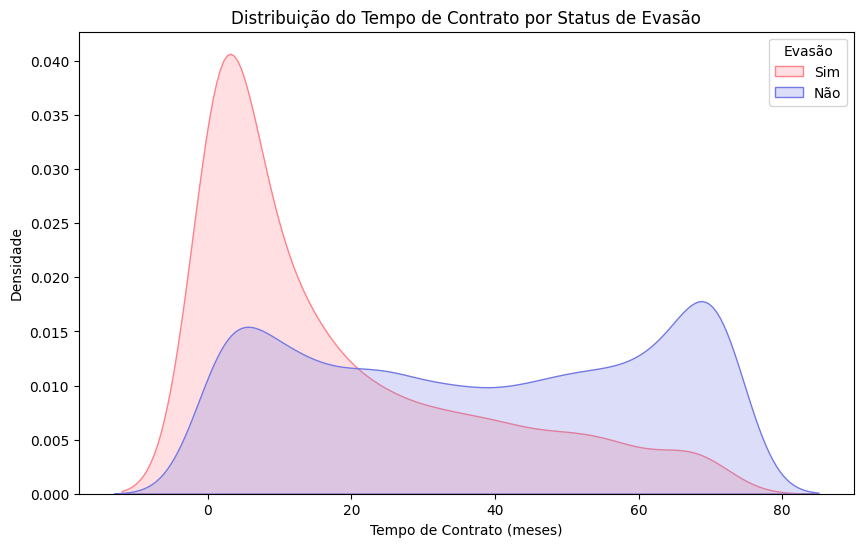

In [ ]:
# Gráfico de densidade (KDE) para comparar as distribuições
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Meses_Contrato', hue='Evasao', fill=True, common_norm=False, palette={'No': '#747ae4', 'Yes': '#ff818a'})
plt.title('Distribuição do Tempo de Contrato por Status de Evasão')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Densidade')
plt.legend(title='Evasão', labels=['Sim', 'Não'])
plt.show()

**b) Total Gasto × Evasão**

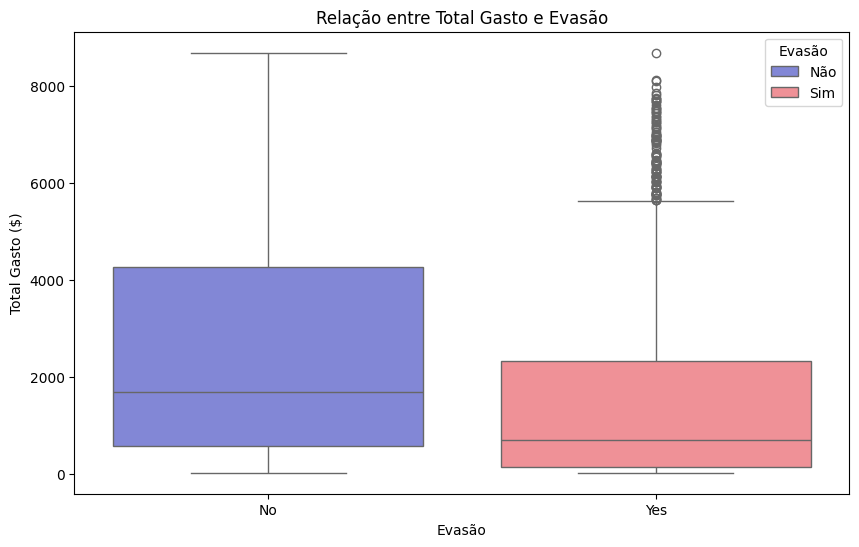

In [ ]:
# Boxplot para visualizar a relação entre total gasto e churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Evasao', y='Gasto_Total', data=df, hue='Evasao', palette=['#747ae4', '#ff818a'], legend=False)
plt.title('Relação entre Total Gasto e Evasão')
plt.xlabel('Evasão')
plt.ylabel('Total Gasto ($)')
plt.legend(title='Evasão', labels=['Não', 'Sim'])
plt.show()

**c) Análise Combinada: Tempo de Contrato vs Total Gasto × Churn**

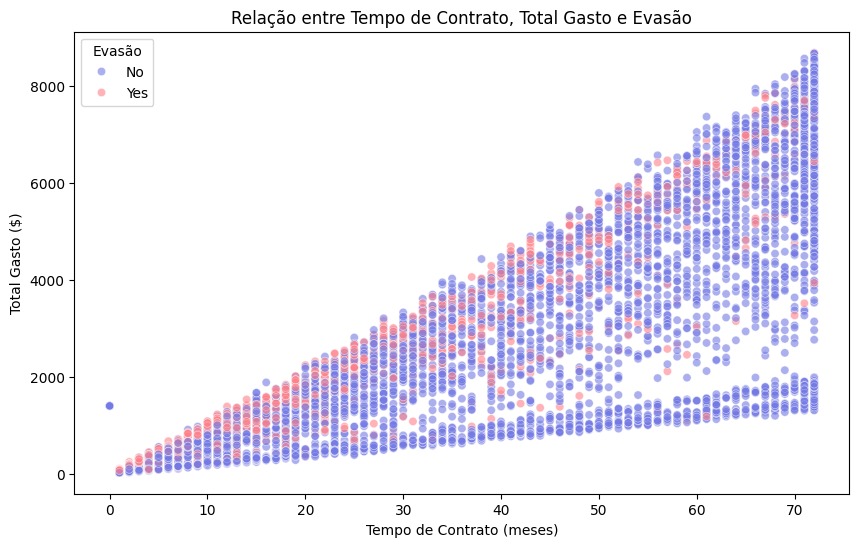

In [ ]:
# Scatter plot com cores por churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Meses_Contrato', y='Gasto_Total', hue='Evasao', data=df, alpha=0.6, palette={'No': '#747ae4', 'Yes': '#ff818a'})
plt.title('Relação entre Tempo de Contrato, Total Gasto e Evasão')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Total Gasto ($)')
plt.legend(title='Evasão')
plt.show()

###3. Seleção de Variáveis Baseada na Análise

In [ ]:
# Antes de dividir os dados, remover todas as colunas relacionadas ao target
cols_to_drop = ['Evasao_Yes', 'Evasao_numeric', 'Evasao']

# Garantir que estamos removendo apenas colunas que existem no DataFrame
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]

# Separar features e target
X = df_processed.drop(cols_to_drop, axis=1)
y = df_processed['Evasao']

# Converter o target em numérico
if y.dtype == 'object':
    y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# Selecionar variáveis com maior correlação (absoluta) com Churn
threshold = 0.15  # Definir limite mínimo de correlação
selected_features = churn_corr[abs(churn_corr) > threshold].index.tolist()

# Remover variáveis-alvo que não fazem parte das features
for col in ['Evasao', 'Evasao_numeric']:
    if col in selected_features:
        selected_features.remove(col)

# Garantir que todas as variáveis estão no DataFrame X
selected_features = list(set(selected_features) & set(X.columns))

# Criar novo dataframe apenas com as variáveis selecionadas
X_selected = X[selected_features]

print(f"Variáveis selecionadas para o modelo (correlação > {threshold}):")
print(selected_features)

Variáveis selecionadas para o modelo (correlação > 0.15):
['Suporte_Tecnico_No internet service', 'Possui_Conjuge_Yes', 'Seguranca_Online_No internet service', 'Servico_Internet_Fiber optic', 'Suporte_Tecnico_Yes', 'Forma_Pagamento_Electronic check', 'Tipo_Contrato_One year', 'Streaming_Filmes_No internet service', 'Tipo_Contrato_Two year', 'Possui_Dependentes_Yes', 'Seguranca_Online_Yes', 'Protecao_Dispositivo_No internet service', 'Meses_Contrato', 'Fatura_Digital_Yes', 'Streaming_TV_No internet service', 'Idoso', 'Gasto_Mensal', 'Contas_Diarias', 'Gasto_Total', 'Servico_Internet_No', 'Backup_Online_No internet service']


**a) Separação dos dados em treino e teste**

Os dados foram divididos em conjuntos de treino e teste, com **70% para treino** e **30% para teste**, utilizando estratificação na variável `Evasao` para garantir que a proporção de clientes que cancelaram fosse mantida em ambos os conjuntos.

In [ ]:
from sklearn.model_selection import train_test_split

# Antes de dividir os dados, remover todas as colunas relacionadas ao target
cols_to_drop = ['Evasao_Yes', 'Evasao_numeric', 'Evasao']

# Garantir que estamos removendo apenas colunas que existem no DataFrame
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]

# Separar features e target
X = df_processed.drop(cols_to_drop, axis=1)
y = df_processed['Evasao']

# Converter o target em numérico
if y.dtype == 'object':
    y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# Dividir em treino e teste antes de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



**b) Balanceamento das classes**

Foi utilizado SMOTE no conjunto de treino para lidar com o desbalanceamento entre classes (Evasao ≈ 26%), para igualar a proporção das classes.

In [ ]:
from imblearn.over_sampling import SMOTE
# Aplicar SMOTE apenas nos dados de treino
churn_distribution = y_train.value_counts(normalize=True)

if churn_distribution.min() < 0.3:  # Checar se a classe minoritária é <30%
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Verificar novo balanceamento
    print("Novo balanceamento após SMOTE:", pd.Series(y_train_smote).value_counts(normalize=True))
else:
    X_train_smote, y_train_smote = X_train, y_train
    print("Balanceamento de classes satisfatório, SMOTE não aplicado.")

Novo balanceamento após SMOTE: Evasao
0    0.5
1    0.5
Name: proportion, dtype: float64


**c) Normalização ou Padronização (se necessário)**

Foi realizada com StandardScaler nos dados de treino e teste, importante para modelos sensíveis à escala.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identificar quais modelos serão usados
# Se usar modelos sensíveis a escala (Regressão Logística, SVM, KNN, Redes Neurais):
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Para modelos baseados em árvore, podemos manter os dados originais
X_train_tree = X_train_smote
X_test_tree = X_test

# 🤖 Modelagem Preditiva

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

###1. Criação e avaliação dos Modelos

Cada modelo foi analisado utilizando as seguintes métricas:
- Acurácia
- Precisão
- Recall
- F1-score
- Matriz de confusão

#### **Modelo 1: Regressão Logística**

**Justificativa:** é um modelo linear simples, interpretável e eficiente para classificação binária; ideal para estabelecer um baseline.

É necessária a normalização porque a Regressão Logística é sensível à escala das variáveis.

              precision    recall  f1-score   support

  Não Evasão       0.84      0.89      0.87      1552
      Evasão       0.64      0.54      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113


Pontuação AUC: 0.8403


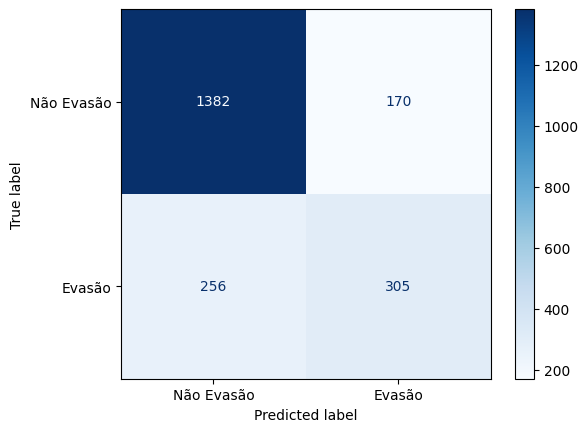

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Normalização para o Modelo de Regressão Logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo
modelo_lr = LogisticRegression(random_state=42, max_iter=1000)
modelo_lr.fit(X_train_scaled, y_train)

# Avaliar
y_pred = modelo_lr.predict(X_test_scaled)

print(classification_report(y_test, y_pred, target_names=['Não Evasão', 'Evasão']))

auc_lr = roc_auc_score(y_test, modelo_lr.predict_proba(X_test_scaled)[:, 1])
print(f"\nPontuação AUC: {auc_lr:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=['Não Evasão', 'Evasão'],
                                        cmap='Blues')

#### **Modelo 2: Random Forest**

**Justificativa:** é um modelo baseado em árvores não sensível à escala; captura relações não-lineares entre features; tem menor risco de overfitting; e não depende da escala dos dados.

Não necessária a normalização, pois o algoritmo compara divisões baseadas em thresholds.

              precision    recall  f1-score   support

  Não Evasão       0.93      0.58      0.71      1552
      Evasão       0.43      0.88      0.58       561

    accuracy                           0.66      2113
   macro avg       0.68      0.73      0.65      2113
weighted avg       0.80      0.66      0.68      2113


Pontuação AUC: 0.8075


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


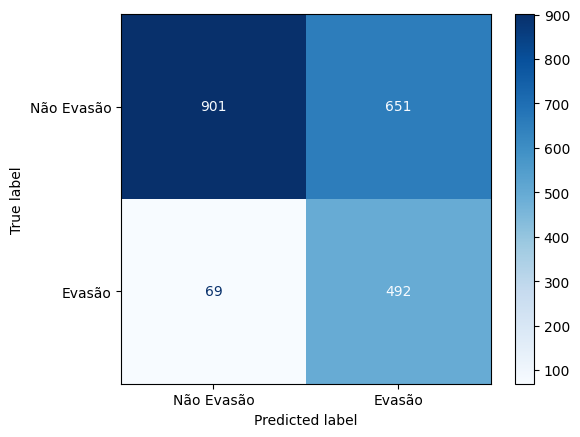

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Treinar modelo Random Forest
modelo_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,  # Limitar profundidade para evitar overfitting
    min_samples_split=10,  # Aumentar para mais generalização
    random_state=42,
    class_weight="balanced_subsample"
)
modelo_rf.fit(X_train, y_train)

# Avaliar
y_pred_rf = modelo_rf.predict(X_test_scaled)

print(classification_report(y_test, y_pred_rf, target_names=['Não Evasão', 'Evasão']))

auc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(X_test_scaled)[:, 1])
print(f"\nPontuação AUC: {auc_rf:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf,
                                        display_labels=['Não Evasão', 'Evasão'],
                                        cmap='Blues')

###2. Análise Crítica e Comparação

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

# Avaliação Regressão Logística
print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred, target_names=['Não Evasao', 'Evasao']))
print("AUC:", roc_auc_score(y_test, modelo_lr.predict_proba(X_test_scaled)[:, 1]).round(4))

# Avaliação Random Forest
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=['Não Evasao', 'Evasao']))
print("AUC:", roc_auc_score(y_test, modelo_rf.predict_proba(X_test)[:, 1]).round(4))

=== Regressão Logística ===
              precision    recall  f1-score   support

  Não Evasao       0.84      0.89      0.87      1552
      Evasao       0.64      0.54      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

AUC: 0.8403

=== Random Forest ===
              precision    recall  f1-score   support

  Não Evasao       0.93      0.58      0.71      1552
      Evasao       0.43      0.88      0.58       561

    accuracy                           0.66      2113
   macro avg       0.68      0.73      0.65      2113
weighted avg       0.80      0.66      0.68      2113

AUC: 0.841


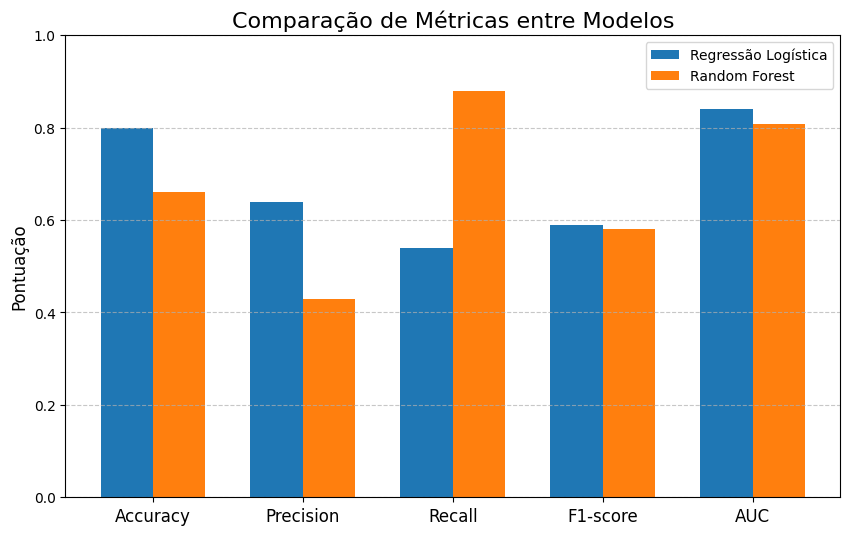

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Métricas obtidas
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "AUC"]

# Valores das métricas (coloquei os que você me passou)
log_reg_results = [0.80, 0.64, 0.54, 0.59, 0.8403]   # Regressão Logística
rf_results      = [0.66, 0.43, 0.88, 0.58, 0.8075]   # Random Forest

# Gráfico de barras lado a lado
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, log_reg_results, width, label="Regressão Logística")
plt.bar(x + width/2, rf_results, width, label="Random Forest")

# Configurações do gráfico
plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Pontuação", fontsize=12)
plt.title("Comparação de Métricas entre Modelos", fontsize=16)
plt.legend()
plt.ylim(0,1)  # para manter escala entre 0 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 📝Interpretação e Conclusões

### 1. Análise de Importância das Variáveis

**a) Regressão Logística**

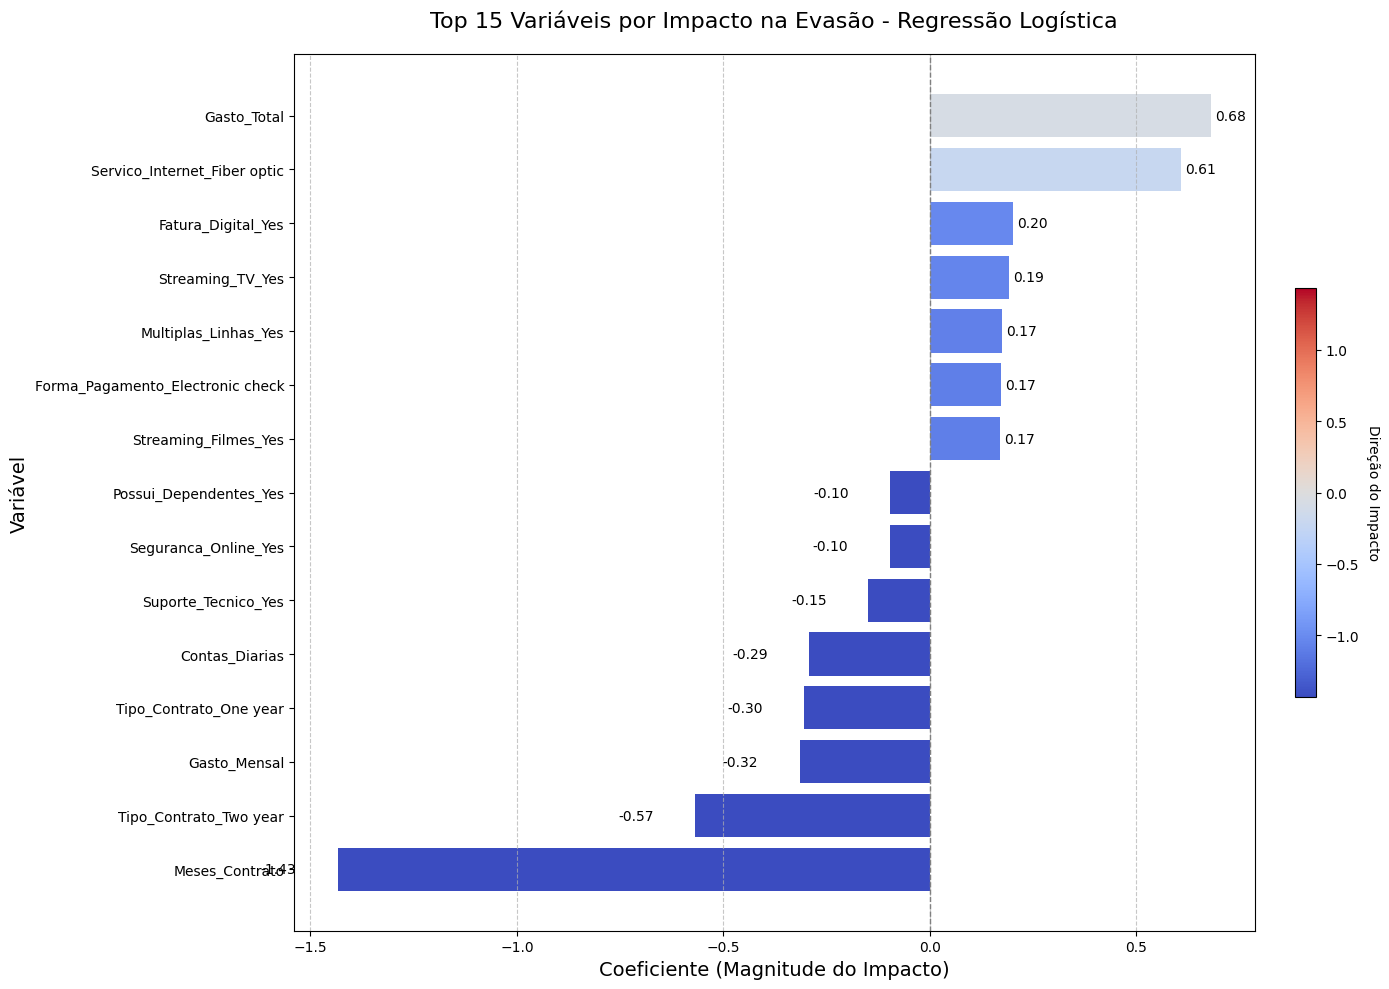

In [ ]:
# Importância das variáveis na Regressão Logística

# Coeficientes da regressão logística
coefficients = modelo_lr.coef_[0]
features = X_train.columns

# Criar DataFrame com os coeficientes
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])

# Selecionar as top variáveis (positivas e negativas combinadas)
top_coef = coef_df.nlargest(15, 'Abs_Coefficient')

# Ordenar do menor para maior valor (para centralizar as barras menores)
top_coef = top_coef.sort_values('Coefficient', ascending=True)

# Plotar
plt.figure(figsize=(14, 10))
bars = plt.barh(top_coef['Feature'], top_coef['Coefficient'],
                color=plt.cm.coolwarm(top_coef['Coefficient'] / top_coef['Coefficient'].abs().max()))

# Adicionar linha vertical no zero
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Adicionar rótulos com valores
for bar in bars:
    width = bar.get_width()
    label_text = f"{width:.2f}"
    label_x = width + (0.01 if width > 0 else -0.1)  # Ajuste de posição
    plt.text(label_x, bar.get_y() + bar.get_height()/2, label_text,
             va='center', ha='left' if width > 0 else 'right',
             fontsize=10, color='black')

# Títulos e legendas
plt.title('Top 15 Variáveis por Impacto na Evasão - Regressão Logística', fontsize=16, pad=20)
plt.xlabel('Coeficiente (Magnitude do Impacto)', fontsize=14)
plt.ylabel('Variável', fontsize=14)

# Barra de cores (colorbar)
sm = plt.cm.ScalarMappable(cmap='coolwarm',
                          norm=plt.Normalize(vmin=-top_coef['Coefficient'].abs().max(),
                                           vmax=top_coef['Coefficient'].abs().max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Direção do Impacto', rotation=270, labelpad=15)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**b) Random Forest**

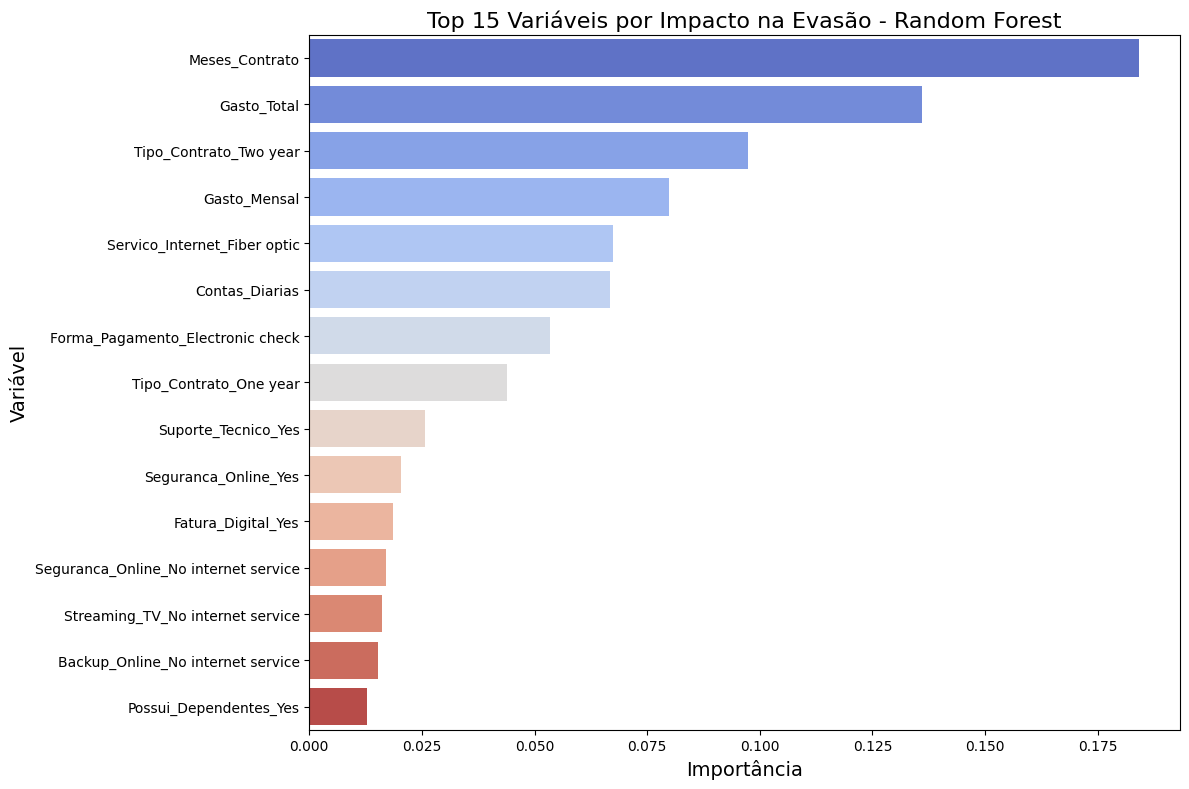

In [ ]:
# Importância das variáveis no Random Forest
feature_importance = modelo_rf.feature_importances_
feature_names = X_train.columns

# Criar DataFrame com as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)

# Plotar
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='coolwarm')
plt.title('Top 15 Variáveis por Impacto na Evasão - Random Forest', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Variável', fontsize=14)
plt.tight_layout()
plt.show()

**c) Comparação da Importância das Variáveis entre Modelos**

<Figure size 1400x800 with 0 Axes>

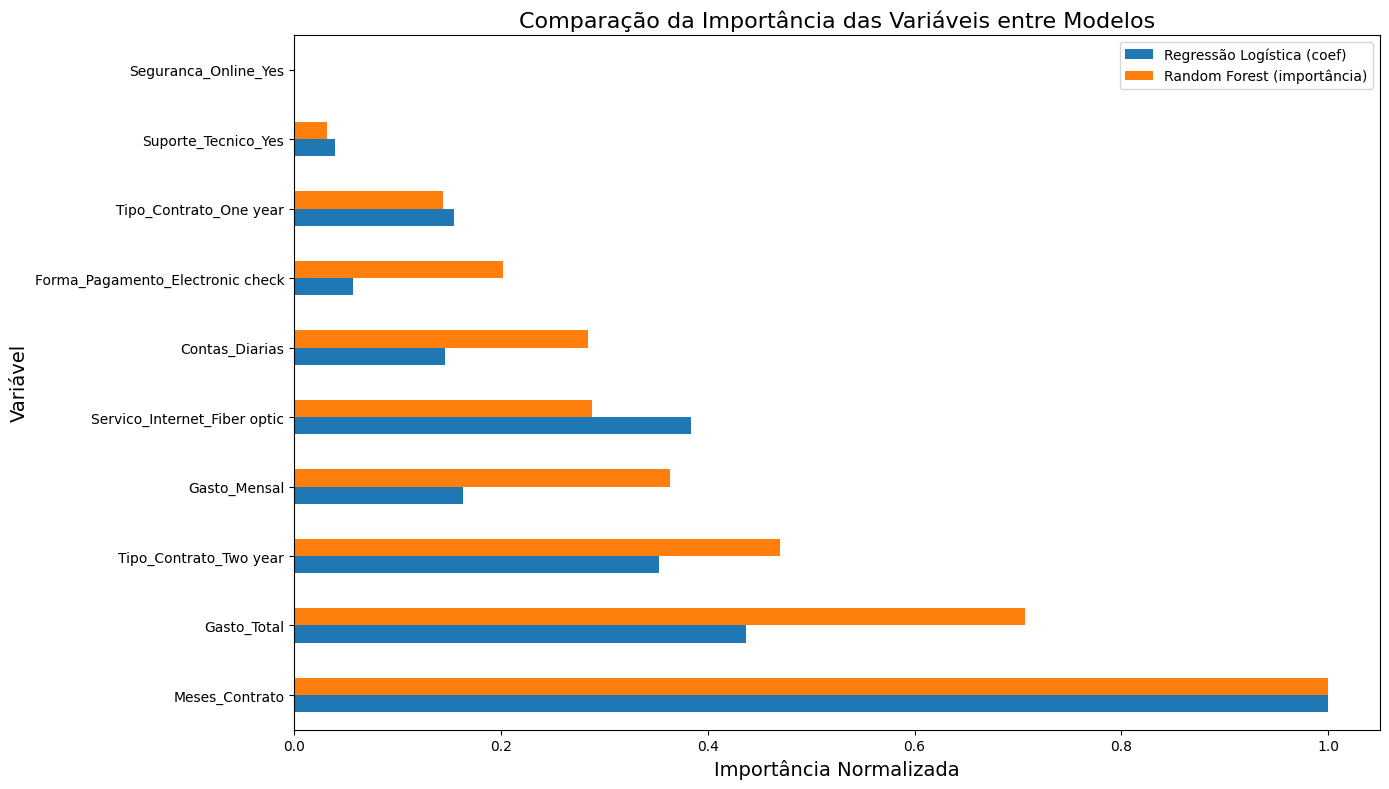

In [ ]:
# Juntar os resultados
comparison_df = coef_df.merge(importance_df, on='Feature', how='outer')
comparison_df = comparison_df.sort_values('Importance', ascending=False).head(10)

# Normalizar os valores para comparação
comparison_df['Coefficient_norm'] = (comparison_df['Abs_Coefficient'] - comparison_df['Abs_Coefficient'].min()) / \
                                   (comparison_df['Abs_Coefficient'].max() - comparison_df['Abs_Coefficient'].min())
comparison_df['Importance_norm'] = (comparison_df['Importance'] - comparison_df['Importance'].min()) / \
                                  (comparison_df['Importance'].max() - comparison_df['Importance'].min())

# Plotar comparação
plt.figure(figsize=(14, 8))
comparison_df.set_index('Feature')[['Coefficient_norm', 'Importance_norm']].plot(kind='barh', figsize=(14, 8))
plt.title('Comparação da Importância das Variáveis entre Modelos', fontsize=16)
plt.xlabel('Importância Normalizada', fontsize=14)
plt.ylabel('Variável', fontsize=14)
plt.legend(['Regressão Logística (coef)', 'Random Forest (importância)'])
plt.tight_layout()
plt.show()

# 📝 **Relatorio Final**


## 📄**Introdução**
A Telecom X está enfrentando um alto índice de cancelamentos (churn), impactando sua receita e base de clientes.

Com a intenção da empresa em antecipar possíveis cancelamentos, este relatório apresenta os resultados dos modelos preditivos capazes de prever quais clientes têm maior chance de cancelar os serviços contratados.

---
## 🛠️ **Preparação de dados**
- **Remoção de colunas irrelevantes** devido à multicolinearidade.
- **Encoding**: aplicação de `OneHotEncoder` com `ColumnTransformer` para transformar as variáveis categóricas em formato numérico para torná-las compatíveis com algoritmos de Machine Learning.
- **Verificação da Proporção de Evasão** para identificar a proporção de clientes que evadiram em relação aos que permaneceram ativos.
- **Balanceamento de Classes** foi feito com SMOTE no conjunto de treino para lidar com o desbalanceamento entre classes (Evasão = 26,5%), igualando a proporção das classes.
-**Normalização ou Padronização**: foi aplicado `StandardScaler` para normalização de dados de treino e teste. É importante para modelos sensíveis à escala.
- Modelos baseados em distância, como KNN, SVM, Regressão Logística e Redes Neurais, **requerem** esse pré-processamento.
- Já modelos baseados em árvore, como Decision Tree, Random Forest e XGBoost, não são sensíveis à escala dos dados.

---
## 📈 **Análise de correlação**
Uma matriz de correlação foi criada para identificar relações entre variáveis numéricas, para focar especialmente quais variáveis apresentam maior correlação com a evasão, pois elas podem ser fortes candidatas para o modelo preditivo.

Foram filtradas variáveis que tinham correlação absoluta >= limiar com a variável alvo para a criação de uma nova matriz

Com base nos resultados da análise do novo heatmap de correlação onde o gráfico mostrou as **correlações ≥ 0.2 (ou ≤ -0.2)** com a variável-alvo Evasao_Yes, tivemos:


**Correlação com `Evasao_Yes` (variável alvo)**

| Variável                                 | Correlação com Evasao\_Yes | Interpretação                                                                                                   |
| ---------------------------------------- | ------------------------- | --------------------------------------------------------------------------------------------------------------- |
| `Servico_Internet_Fiber optic`   | **+0.31**                 | Clientes com fibra ótica têm **maior chance de churn**. Pode estar relacionado ao custo ou à competitividade.   |
| `Forma_Pagamento_Electronic check` | **+0.30**                 | Pagamentos por boleto eletrônico estão associados a mais churn — talvez por perfil de cliente menos fidelizado. |
| `Meses_Contrato`                        | **-0.35**                 | Quanto maior o tempo como cliente, menor a chance de churn — esperado                                           |
| `Tipo_Contrato_Two year`              | **-0.30**                 | Contratos de 2 anos reduzem o churn (clientes mais engajados ou com benefícios)                                 |
| `Serviço_Internet_No`            | **-0.23**                 | Quem **não usa internet** tende a churnar menos — possivelmente perfis mais estáveis (idosos, menos digitais)   |


---
### 📊 Análises Direcionadas
Com o objetivo de entender o comportamento de variáveis que, teoricamente, podem influenciar a evasão, foram criados gráficos boxplot para visualizar padrões e possíveis tendências. A hipótese é que clientes com maior tempo de permanência e maior valor investido tendem a permanecer na empresa.

Os resultados mostraram que:
- **Tempo de Contrato × Evasão**: quanto menor tempo de contrato, maior a evasão.
- **Total Gasto × Evasão**: quanto mais gasto com serviços, menor é a frequência de evasão.
- A mediana do tempo de contrato é visivelmente maior para o grupo que permaneceu, reforçando a ideia de que tempo de relacionamento é um fator protetor contra a evasão.
- Esse padrão sugere que estratégias voltadas para aumentar o engajamento nos primeiros meses podem ser eficazes para reduzir a evasão. Além disso, programas de fidelidade ou benefícios

Um **Scatterplot** também foi criado para visualizar a entre `Tempo_Contrato` e `Gasto_total` com `Evasao`, reforçando que clientes de longo prazo e com alto gasto total são menos propensos a cancelar os serviços da empresa.

Os resultados mostraram que:
- Existe uma correlação positiva entre tempo de contrato e total gasto, como esperado.
- A evasão está fortemente associado a clientes com pouco tempo de relacionamento e baixo investimento financeiro.
- Clientes que permanecem por mais tempo tendem a acumular maior gasto e demonstram maior fidelidade.
- Implicações estratégicas para evitar evasão podem ser: foco em retenção nos primeiros meses é essencial; oferecer benefícios progressivos ou incentivos iniciais pode ajudar a reduzir churn precoce; e monitorar clientes com baixo tempo de contrato e baixo gasto pode permitir ações preventivas antes da evasão.



---
## 🤖 **Modelagem Preditiva**
Na modelagem preditiva, é essencial preparar os dados corretamente. Um dos primeiros passos é separar os dados em conjuntos de treino e teste, permitindo que o modelo aprenda com parte dos dados e seja testado com outra parte que ele ainda não viu.

Neste caso, foi usada a função `train_test_split`, com 70% dos dados para treino e 30% para teste. A estratificação foi aplicada com base na variável churn, garantindo que a proporção das classes fosse mantida nos dois conjuntos. Isso ajuda a evitar distorções quando as classes estão desbalanceadas.

Foram treinados dois modelos de classificação utilizando os dados de treino previamente balanceados e padronizados, os quais posteriormente foram avaliados no conjunto de teste.

Os algoritmos escolhidos foram: **Regressão Logística**, que exige normalização dos dados para melhor desempenho, e **Random Forest**, que não possui essa exigência devido à sua natureza baseada em árvores de decisão.

As métricas de avaliação de cada modelo utilizadas foram as seguintes:
- Acurácia
- Precisão
- Recall
- F1-score
- Matriz de confusão


### 📊 Desempenho dos Modelos no Conjunto de Teste

**Comparação entre Regressão Logística e Random Forest**

|Critério           | Regressão Logística (RL)| Random Forest (RF)| Interpretação                                                                                                   |
| --------------- --| ----------------------- |------------------ |--------------------------------|
|Acurácia           |0.80       |0.66         |RL tem desempenho mais equilibrado no conjunto inteiro. |
|Recall (evasão)    |0.54       |0.88         |RF detecta quase todos os clientes que vão evadir (melhor para reduzir perdas). |
|Precisão (evasão)  |0.64       |0.43         |RL é mais confiável ao prever evasão (menos falsos alarmes).  |
|F1-score (evasao)  |0.59       |0.58         |Muito próximos, mas a RL é levemente superior em equilíbrio. |
|AUC                |0.84        |0.81        |Ambos bons discriminadores, mas logística leva vantagem. |

**Impactos dos modelos:**
- **Regressão Logística**: É mais equilibrada, não acerta todos os churns, mas mantém boa precisão e recall. Evita desperdiçar recursos retendo clientes que não iam sair, mas pode deixar churns passarem despercebidos.
-**Random Forest**: Detecta quase todos os churns, mas pode gerar sobrecarga de ações de retenção em clientes que não sairiam. Ele prefere errar chamando alguém de evasão (mesmo que não seja) do que deixar de detectar um churn verdadeiro. Isso aumenta o recall, mas prejudica a acurácia geral.



### 📌Análise de Importância das Variáveis(Principais fatores de evasão de clientes)
A análise dos coeficientes da Regressão Logística e da importância das variáveis do Random Forest revelou os seguintes fatores que impactaram na previsão de evasão:

- **Regressão Logística**: tempo de contrato, tipo de contrato, gasto mensal, e contas diárias.
- **Random Forest**: tempo de contrato, gasto total, tipo de contrato, gasto mensal, serviço de internet (fibra ótica) e contas diárias.

Em ambos os modelos, o tempo de contrato foi a variável que assumiu como principal fator de evasão dos clientes.


---
## 🏆 **Conclusão sobre o Melhor Modelo**
**Regressão Logística**:
- Melhor em identificar clientes que não vão cancelar (alta precisão para “Não Evasão”).
- Pior em capturar quem realmente cancela (recall baixo para “Evasão”).
- **Interpretação**: o modelo ajuda a entender fatores de risco gerais, mas pode deixar escapar as evasões.

**Random Forest**:
- Melhor em detectar clientes que cancelam (recall alto para “Evasão” = 0.88).
- Pior em precisão (muitos falsos positivos).
- **Interpretação**: bom para alertar potenciais evasões, mas pode acionar clientes que não sairiam.

RESUMINDO:
- Se a prioridade é prever com confiança quem vai sair, e se  o objetivo principal da Telecom X é minimizar perda de clientes a qualquer custo, → **Random Forest** é mais indicado.
- Se o orçamento para retenção é limitado e a empresa precisa ser assertiva, → **Regressão Logística** é mais indicada.

---
##✅ **Recomendações**
Algumas estratégias de retenção de clientes podem ser enumeradas como as seguintes:

1. **Segmentação de Clientes em Risco**
- Usar a Random Forest para identificar clientes com alto risco de evasão.
- Criar campanhas preventivas direcionadas, como contato ativo da equipe de suporte, e ofertas personalizadas (descontos, upgrades, flexibilização de contrato).

2. **Foco em Fatores de Maior Impacto**
- Pelas importâncias das variáveis no Random Forest, identificar quais atributos mais influenciam o churn.
-Incentivar contratos de maior prazo (descontos progressivos em anual/semestral).
- Incluir serviços de valor agregado com custo reduzido.

3. **Programa de Fidelidade e Benefícios**
- Clientes com maior tempo de casa (tenure) tendem a ser mais leais.
- Criar para eles um programa de pontos/recompensas para estimular permanência, e reconhecer clientes antigos com bônus ou upgrades gratuitos

4. **Atendimento Proativo**
- Clientes que não possuem conjuge/dependentes podem ter maior chance de sair (fidelidade menor).
- Promover ações personalizadas: contato proativo, pesquisa de satisfação, resolução de problemas antes de cancelarem.

5. **Monitoramento Contínuo**
- **Acurácia da Regressão Logística (0.80)** → indica ser boa para fornecer um perfil geral do cliente típico fiel.
- **Recall da Random Forest (0.88)** → indica que seria bom criar uma lista de clientes em risco.
